# TELCO PROJECT

In [288]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing

# NOTES AND TAKEAWAYS

## Univariate notes
    # Not many senior citizens
    # tenure is like an inverse normal curve. Skewed toward the low and high ends. Those low end values are dragging the avg down a litle
    # a lot of low total charges are dragging down the avg. not normal-->mann whitney test later?
    # none of these features seems very 'normally' distributed, expect to do some hypothesis testing
    # many more "no churn" accounts, so this will be our baseline
    
    #probably some chi2 testing on different categoricals in bivariate analysis. churn/payment type for ex
    #mann whitney for some of those continuos values (monthly and total charges, really)

In [2]:
raw_telco_df = acquire.get_telco_data()
raw_telco_df.sample(50)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
3601,1,2,1,0963-ZBDRN,Male,0,No,No,32,Yes,...,Yes,Yes,Yes,Yes,96.20,3183.4,Yes,Month-to-month,Fiber optic,Electronic check
4755,4,2,1,6259-WJQLC,Male,1,No,No,32,Yes,...,No,No,No,Yes,81.10,2619.25,No,Month-to-month,Fiber optic,Credit card (automatic)
1034,4,1,2,7100-FQPRV,Male,0,Yes,Yes,43,Yes,...,Yes,No,Yes,Yes,71.90,3173.35,No,One year,DSL,Credit card (automatic)
4295,1,2,1,4220-TINQT,Female,0,Yes,No,61,Yes,...,Yes,Yes,Yes,Yes,106.35,6751.35,No,Month-to-month,Fiber optic,Electronic check
3146,2,2,2,5343-SGUBI,Female,0,No,No,52,Yes,...,No,No,No,Yes,80.20,4297.6,No,One year,Fiber optic,Mailed check
5601,2,3,3,1270-XKUCC,Female,0,Yes,Yes,30,Yes,...,No internet service,No internet service,No internet service,No,19.70,599.25,No,Two year,None,Mailed check
6600,4,3,1,1552-TKMXS,Female,0,Yes,No,42,Yes,...,No internet service,No internet service,No internet service,No,20.35,869.9,No,Month-to-month,None,Credit card (automatic)
4769,2,2,1,6347-DCUIK,Male,0,No,No,10,Yes,...,No,No,No,Yes,74.15,811.8,Yes,Month-to-month,Fiber optic,Mailed check
47,3,1,3,0707-HOVVN,Female,1,No,No,70,Yes,...,Yes,Yes,No,Yes,75.50,5212.65,No,Two year,DSL,Bank transfer (automatic)
19,4,1,3,0336-KXKFK,Male,0,No,No,72,No,...,Yes,Yes,Yes,Yes,61.20,4390.25,No,Two year,DSL,Credit card (automatic)


In [3]:
raw_telco_df.shape

(7043, 24)

In [4]:
raw_telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
raw_telco_df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


# I utilized my prep_telco and split_telco_data functions from prepare.py to get the data ready

### Remember how we call functions from file please

In [6]:
# take note of how we had to call the prepare.py file here
telco_prepped = prepare.prep_telco(raw_telco_df)

In [7]:
telco_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   customer_id                             7043 non-null   object  
 1   gender                                  7043 non-null   object  
 2   senior_citizen                          7043 non-null   int64   
 3   partner                                 7043 non-null   object  
 4   dependents                              7043 non-null   object  
 5   tenure                                  7043 non-null   int64   
 6   phone_service                           7043 non-null   object  
 7   multiple_lines                          7043 non-null   object  
 8   online_security                         7043 non-null   object  
 9   online_backup                           7043 non-null   object  
 10  device_protection                       7043 non

In [8]:
#here, we reassign the three values returned from the split_data function to new variables
telco_train, telco_validate, telco_test = prepare.split_telco_data(telco_prepped)
print(f'telco_train: {telco_train.shape}')
print(f'telco_validate: {telco_validate.shape}')
print(f'telco_test: {telco_test.shape}')

telco_train: (3943, 61)
telco_validate: (1691, 61)
telco_test: (1409, 61)


In [9]:
# telco_train.isnull().sum()
# #great, no null values

In [10]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

telco_X_train = telco_train.drop(columns=['churn_Yes'])
telco_y_train = telco_train.churn_Yes

telco_X_validate = telco_validate.drop(columns=['churn_Yes'])
telco_y_validate = telco_validate.churn_Yes

telco_X_test = telco_test.drop(columns=['churn_Yes'])
telco_y_test = telco_test.churn_Yes

In [11]:
print(f'telco_X_train: {telco_X_train.shape}')
print(f'telco_y_train: {telco_y_train.shape}')


print(f'telco_X_validate: {telco_X_validate.shape}')
print(f'telco_y_validate: {telco_y_validate.shape}')


print(f'telco_X_test: {telco_X_test.shape}')
print(f'telco_y_test: {telco_y_test.shape}')

telco_X_train: (3943, 60)
telco_y_train: (3943,)
telco_X_validate: (1691, 60)
telco_y_validate: (1691,)
telco_X_test: (1409, 60)
telco_y_test: (1409,)


# At this point, we now have our train, validate, test data sets

In [12]:
telco_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 3281 to 2601
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   customer_id                             3943 non-null   object  
 1   gender                                  3943 non-null   object  
 2   senior_citizen                          3943 non-null   int64   
 3   partner                                 3943 non-null   object  
 4   dependents                              3943 non-null   object  
 5   tenure                                  3943 non-null   int64   
 6   phone_service                           3943 non-null   object  
 7   multiple_lines                          3943 non-null   object  
 8   online_security                         3943 non-null   object  
 9   online_backup                           3943 non-null   object  
 10  device_protection                       3943 

In [13]:
telco_X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3943.0,0.155212,0.362152,0.00,0.000,0.00,0.000,1.00
tenure,3943.0,32.910221,24.820268,0.00,9.000,30.00,56.000,72.00
monthly_charges,3943.0,64.766510,30.243547,18.25,35.025,70.20,90.100,118.75
total_charges,3943.0,2329.698821,2308.535478,0.00,398.225,1415.85,3917.275,8684.80
gender_Male,3943.0,0.495308,0.500041,0.00,0.000,0.00,1.000,1.00
partner_Yes,3943.0,0.481613,0.499725,0.00,0.000,0.00,1.000,1.00
dependents_Yes,3943.0,0.300786,0.458658,0.00,0.000,0.00,1.000,1.00
phone_service_Yes,3943.0,0.900076,0.299937,0.00,1.000,1.00,1.000,1.00
multiple_lines_No phone service,3943.0,0.099924,0.299937,0.00,0.000,0.00,0.000,1.00
multiple_lines_Yes,3943.0,0.425564,0.494491,0.00,0.000,0.00,1.000,1.00


# Univariate analysis:

In [14]:
telco_X_train.head().T

,3281,1786,6678,5627,2433
customer_id,7940-UQQUG,4749-VFKVB,2839-RFSQE,1734-ZMNTZ,0266-CLZKZ
gender,Female,Female,Female,Female,Female
senior_citizen,0,0,0,0,0
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,Yes,Yes
tenure,64,1,2,11,67
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,Yes,Yes,No,Yes,Yes
online_security,Yes,No,No internet service,No internet service,No
online_backup,No,No,No internet service,No internet service,No


In [15]:
# this cell is isolating the number format columns for analysis below

num_cols = telco_X_train.columns[[telco_X_train[col].dtype in ('int64', 'float64') for col in telco_X_train.columns]]
num_cols = list(num_cols)
to_append = ["gender_Male", "partner_Yes","dependents_Yes"]
for var in to_append:
    num_cols.append(var)

num_cols

['senior_citizen',
 'tenure',
 'monthly_charges',
 'total_charges',
 'gender_Male',
 'partner_Yes',
 'dependents_Yes']

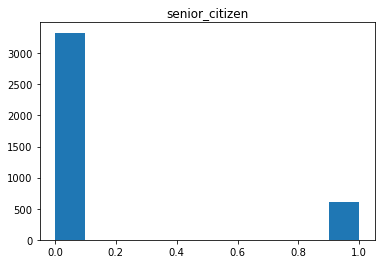

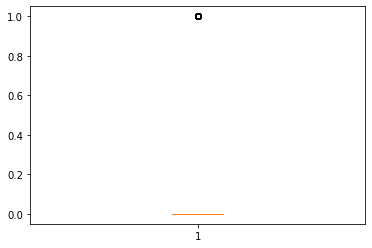

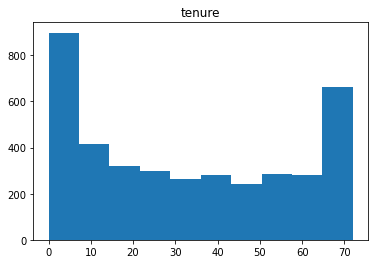

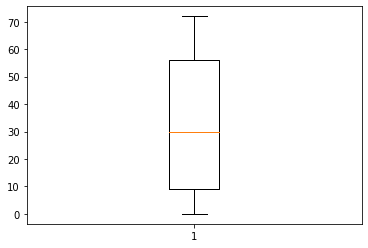

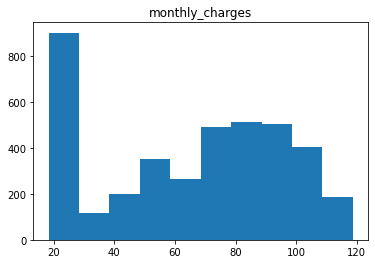

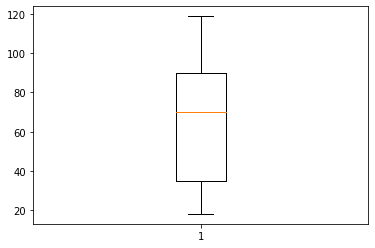

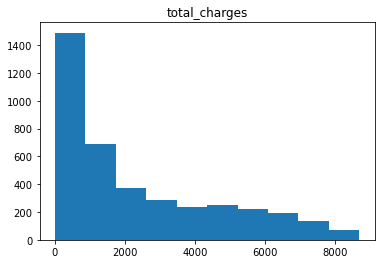

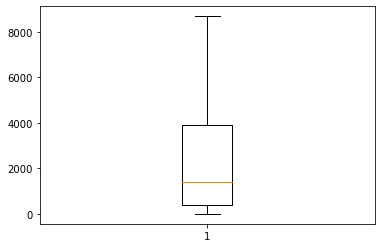

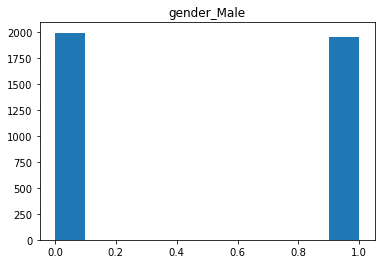

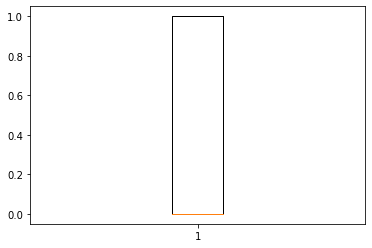

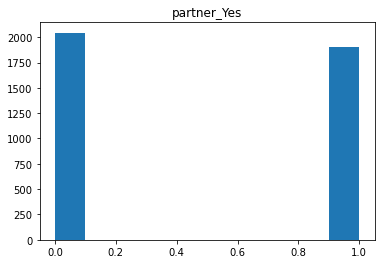

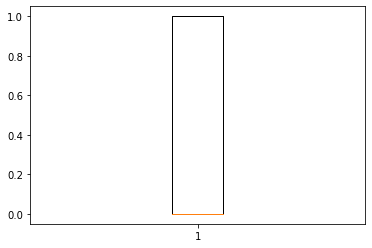

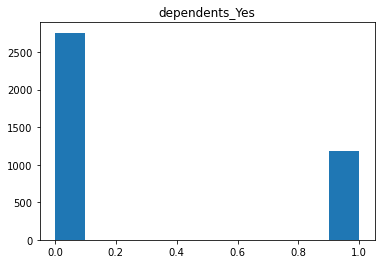

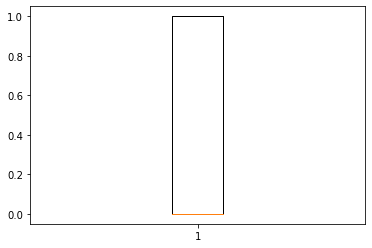

In [16]:
# getting an error now bc i split the churn_Yes feature into the y_train set. doing a separate command for that

# this cell is giving me a histogram and boxplot for all numerical data.  

for col in num_cols:
    telco_X_train[col]
    plt.hist(telco_X_train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(telco_X_train[col])
    plt.show()
#     else:
#         plt.hist(telco_y_train[col]
#         plt.title(col)
#         plt.show()
#         plt.boxplot(telco_y_train[col])
#         plt.show())
# Notes:
# Not many senior citizens
# tenur is like an inverse normals curve. Skewed toward the low and high ends. Those low end values are dragging the avg down a litle
# quite a lot of $20 monthly charges. Just basic phone service, presumably?
# a lot of low total charges, which are dragging down the avg subustantially
# none of these features seems very 'normally' distributed, expect to do some hypothesis testing
# half and half for sex and partner; slightly more peoplo with no dependents


# many more "no churn" accounts, so this will be our baseline

In [17]:
telco_y_train.value_counts()


0    2897
1    1046
Name: churn_Yes, dtype: int64

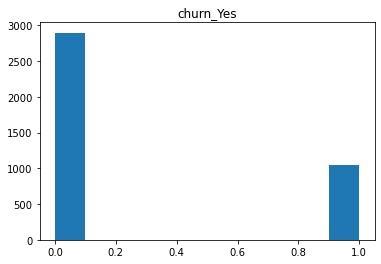

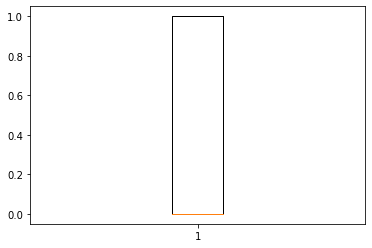

In [18]:
plt.hist(telco_y_train)
plt.title('churn_Yes')
plt.show()
plt.boxplot(telco_y_train)
plt.show()

#roughly 1/4 of the accounts are churned

# "no churn" will be our baseline

# and....nice work repeating work that you had done below. 

In [19]:
# this cell is isolating the columns with a uint8 type for analysis

# uint_cols = telco_train.columns[[telco_train[col].dtype == 'uint8' for col in telco_train.columns]]
# uint_cols

# ON ADAM'S ADVICE, NOT EXPLORING ENCODED FEATURES

In [20]:
# and here, we get an idea of what each uint8 feature contains

# for col in uint_cols:
#     print(telco_train[col].value_counts())
#     print(telco_train[col].value_counts(normalize = True, dropna=False))
#     print('------------------------')
    
# NOTES
# 51% male
# 51% NO partner
# 70% NO dependents
# 90% YES phone service

# ON ADAM'S ADVICE, I'M NOT GOING TO CONTINUE EXPLORING THE ENCODED FEATURES

In [21]:
# this cell is isolating the columns with an object ('O') type for analysis

obj_cols = telco_train.columns[[telco_train[col].dtype == 'O' for col in telco_train.columns]]
obj_cols

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [22]:
# and here, we get an idea of what each object feature contains

for col in obj_cols:
    print(telco_train[col].value_counts())
    print(telco_train[col].value_counts(normalize = True, dropna=False))
    print('------------------------')
    
# 51% male
# 51% no partner
# 70% no dependents
# 90% phone service
# 48% no multiple lines + 9% no phone svc
# 49% no online security + 22% no internet svc
# 43% no internet svc
# 48% no tech support
# 39% no streaming tv
# 39% no streaming movies
# 59% paperless billing
# 73% churn
# 55% month to month contract
# 43% fiber optic
# 33% elecronic check

0670-KDOMA    1
0027-KWYKW    1
6876-ADESB    1
2234-EOFPT    1
6295-OSINB    1
             ..
8824-RWFXJ    1
4951-UKAAQ    1
6169-PPETC    1
8286-AFUYI    1
3523-BRGUW    1
Name: customer_id, Length: 3943, dtype: int64
0670-KDOMA    0.000254
0027-KWYKW    0.000254
6876-ADESB    0.000254
2234-EOFPT    0.000254
6295-OSINB    0.000254
                ...   
8824-RWFXJ    0.000254
4951-UKAAQ    0.000254
6169-PPETC    0.000254
8286-AFUYI    0.000254
3523-BRGUW    0.000254
Name: customer_id, Length: 3943, dtype: float64
------------------------
Female    1990
Male      1953
Name: gender, dtype: int64
Female    0.504692
Male      0.495308
Name: gender, dtype: float64
------------------------
No     2044
Yes    1899
Name: partner, dtype: int64
No     0.518387
Yes    0.481613
Name: partner, dtype: float64
------------------------
No     2757
Yes    1186
Name: dependents, dtype: int64
No     0.699214
Yes    0.300786
Name: dependents, dtype: float64
------------------------
Yes    3549
No     

In [23]:
telco_train.monthly_charges.value_counts(bins=5, sort=False)

# lots of monthly charges at the bottom and upper middle

(18.148999999999997, 38.35]    1020
(38.35, 58.45]                  556
(58.45, 78.55]                  758
(78.55, 98.65]                 1021
(98.65, 118.75]                 588
Name: monthly_charges, dtype: int64

In [24]:
telco_train.total_charges.value_counts(bins=5, sort=False)

#again, total charges considerably skewed

(-8.686, 1736.96]     2180
(1736.96, 3473.92]     655
(3473.92, 5210.88]     486
(5210.88, 6947.84]     411
(6947.84, 8684.8]      211
Name: total_charges, dtype: int64

## Bivariate notes



In [25]:
# telco_X_train.head().T

- Is there a relationship between....
        - sex and churn? no apparent relationship. DON'T PURSUE
        - senior citizen? is_senior ~ higher churn. DON'T PURUE
        - partners and churn? no partner ~ higher churn.  MAYBE PURSUE
        - dependents and churn: no dependents ~ higher churn. MAYBE PURSUE: CHI2  
        - tenure: longer tenure ~ lower churn. DO MANN WHIT (this is not normally distributed)
        - phone service: nothing here. DON'T PURSUE
        - multiple lines: minimally higher churn for multiple lines. DON'T PURSUE
        -streaming tv: minimally higher churn for none. DON'T BOTHER
        -streaming movies: same. DON'T BOTHER
        -Somewhat higher churn for those with paperless billing. PURSUE: SEEMS COUNTERINTUITIVE. DO CHI2
        -contract type: month-to-month has way higher churn.  obvious? MAYBE DON'T PURSUE
        -internet service type: fiber optic has way highest churn. DEF PURSUE. CHI2
        -payment type: electronic check has way highest churn. DEF PURSUE WITH A CHI2
        -monthly charges: Churn increases as do monthly charges, up to a point. MAYBE DON'T PURSUE
        -Churn higher where total charges are least. DON'T PURSUE AFTER ALL, VERY OBVIOUS
        

## NEXT STEP: tests.  Create your hypotheses

### senior citizens: chi2
    - 𝐻𝑜 : Being a senior citizen is unrelated to churn/no churn
    - 𝐻𝑎 : Being a senior citizen is related to churn
            - We reject the null hypothesis

### dependents: chi2
    - 𝐻𝑜 : having dependents is unrelated to churn
    - 𝐻𝑎 : having dependents is related to churn
            - We reject the null hypothesis
        
### tenure: mann-whit
    - 𝐻𝑜 : tenure among churn and non-churn is unrelated
    - 𝐻𝑎 : tenure is related to churn
            - We reject the null hypothesis
        
### paperless billing: chi2
    - 𝐻𝑜 : having paperless billing is unrelated to churn
    - 𝐻𝑎 : having paperless billing is related to churn
            - We reject the null hypothesis
        
### internet service type: chi2
    - 𝐻𝑜 : Fiber Optic internet service type is unrelated to churn
    - 𝐻𝑎 : Fiber Optic internet service type is related to churn
            - We reject the null hypothesis
            
### payment type: chi2
    - 𝐻𝑜 : paying by electronic check is unrelated to churn
    - 𝐻𝑎 : paying by electronic check is related to churn
            - We reject the null hypothesis
        
### total charges and tenure are related.  This is expected, so not especially useful.
    - 𝐻𝑜 : tenure and total charges are not linearly correlated
    - 𝐻𝑎 : tenure and total charges are linearly correlated
            - We reject the null hypothesis

## 1. Are those with dependents paying less?
## 2. Are people with paperless billing being charged differently?
## 3. Are people with longer tenure more loyal? Are they being charged more? Less?
    - analysis implies they don't get charged more.  more loyal by definition, kind of.
## 4. Are senior citizen being charged more for the same service?
## 5. Is there a reason for the Fiber Optic churn, outside of price?

In [26]:
alpha = 0.05

In [27]:
# plt.title("No relationship apparent regarding sex and churn")
# sns.barplot(y=telco_y_train, x="gender", data=telco_X_train)
# plt.legend()
# plt.show()

No handles with labels found to put in legend.


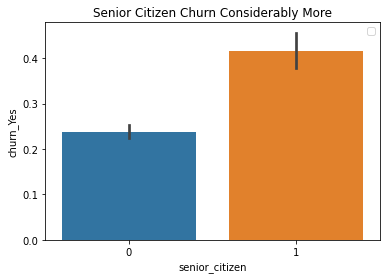

In [28]:
plt.title("Senior Citizen Churn Considerably More")
sns.barplot(y=telco_y_train, x="senior_citizen", data=telco_X_train)
plt.legend()
plt.show()

#chi ^2 test possible

In [29]:
observed_seniors = pd.crosstab(telco_X_train.senior_citizen, telco_y_train)
observed_seniors

churn_Yes,0,1
senior_citizen,,
0,2540,791
1,357,255


    - 𝐻𝑜 : Being a senior citizen is unrelated to churn/no churn
    - 𝐻𝑎 : Being a senior citizen is related to churn

In [30]:
chi2, p, degf, expected = stats.chi2_contingency(observed_seniors)
print('Observed\n')
print(observed_seniors.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[2540  791]
 [ 357  255]]
---
Expected

[[2447  883]
 [ 449  162]]
---

chi^2 = 84.2656
p     = 0.0000
We reject the null hypothesis


In [31]:
# plt.title("There is an apparent relationship between having a partner and churning")
# sns.barplot(y=telco_y_train, x="partner", data=telco_X_train)
# plt.legend()
# plt.show()

# this requires stat testing.  this is categorical against categorical, so chi 2.  h_o and h_a??

No handles with labels found to put in legend.


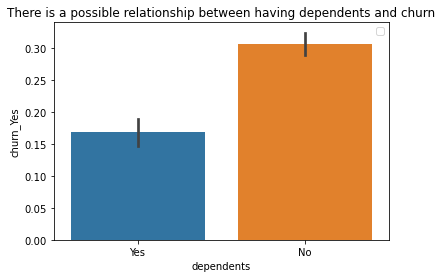

In [32]:
plt.title("There is a possible relationship between having dependents and churn")
sns.barplot(y=telco_y_train, x="dependents", data=telco_X_train)
plt.legend()
plt.show()

# also a stat test: chi^2

In [33]:
observed_dependents = pd.crosstab(telco_X_train.dependents, telco_y_train)
observed_dependents

churn_Yes,0,1
dependents,,
No,1911,846
Yes,986,200


    - 𝐻𝑜 : having dependents is unrelated to churn
    - 𝐻𝑎 : having dependents is related to churn

In [34]:
chi2, p, degf, expected = stats.chi2_contingency(observed_dependents)
print('Observed\n')
print(observed_dependents.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[1911  846]
 [ 986  200]]
---
Expected

[[2025  731]
 [ 871  314]]
---

chi^2 = 80.5787
p     = 0.0000
We reject the null hypothesis


No handles with labels found to put in legend.


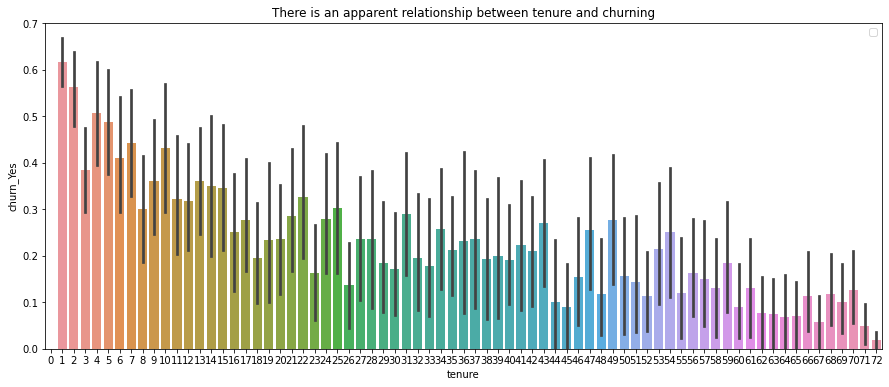

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [35]:
plt.figure(figsize=(15,6))
plt.title("There is an apparent relationship between tenure and churning")
sns.barplot(y=telco_y_train, x="tenure", data=telco_X_train)
plt.legend()
plt.show()
plt.tight_layout

# churn appears to decrease as you have longer tenure.  Continuous vs categorical--> t_test. NO, this is
# not normally distributed.  Look for a non-parametric test.  Mann-whitney

- 𝐻𝑜 : tenure among churn and non-churn is unrelated
- 𝐻𝑎 : tenure is related to churn

In [36]:
# telco_X_train.tenure.hist()
#just checking for distribution type

In [37]:
mann_whit, p_value = scipy.stats.mannwhitneyu(telco_X_train.tenure, telco_y_train, )


if p_value < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
mann_whit, p_value

We reject the null hypothesis


(189649.0, 0.0)

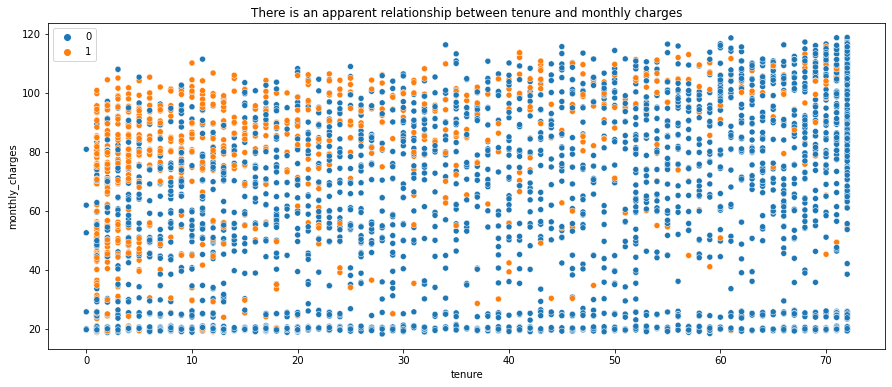

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [38]:
plt.figure(figsize=(15,6))
plt.title("There is an apparent relationship between tenure and monthly charges")
sns.scatterplot(y='monthly_charges', x="tenure", data=telco_X_train, hue=telco_y_train)
plt.legend()
plt.show()
plt.tight_layout

    - 𝐻𝑜 : tenure and monthly charges are unrelated
    - 𝐻𝑎 : tenure is related to monthly charges

In [39]:
corr, p = stats.pearsonr(telco_X_train.tenure, telco_X_train.monthly_charges)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p



#AWFULLY LIGHT CORRELATION

We reject the null hypothesis


(0.26418098021196357, 5.863503661190746e-64)

In [40]:
# plt.title("No relationship apparent regarding phone service and churn")
# sns.barplot(y=telco_y_train, x="phone_service", data=telco_X_train)
# plt.legend()
# plt.show()

In [41]:
# plt.title("Minimally higher churn for multiple lines")
# sns.barplot(y=telco_y_train, x="multiple_lines", data=telco_X_train)
# plt.legend()
# plt.show()

# #not pursuing

In [42]:
# plt.title("Minimally higher churn for no streaming tv")
# sns.barplot(y=telco_y_train, x="streaming_tv", data=telco_X_train)
# plt.legend()
# plt.show()

# # not pursuing

In [43]:
# plt.title("Minimally higher churn for no streaming movies")
# sns.barplot(y=telco_y_train, x="streaming_movies", data=telco_X_train)
# plt.legend()
# plt.show()

# # not pursuing

No handles with labels found to put in legend.


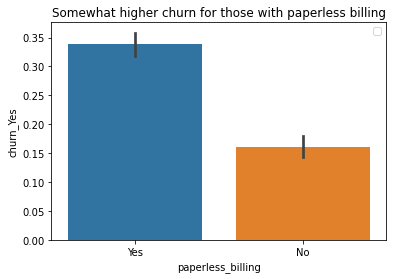

In [44]:
plt.title("Somewhat higher churn for those with paperless billing")
sns.barplot(y=telco_y_train, x="paperless_billing", data=telco_X_train)
plt.legend()
plt.show()

# stats test this with the chi-2

In [45]:
telco_X_train.paperless_billing.value_counts()

Yes    2314
No     1629
Name: paperless_billing, dtype: int64

In [46]:
observed_billing = pd.crosstab(telco_X_train.paperless_billing, telco_y_train)
observed_billing

churn_Yes,0,1
paperless_billing,,
No,1366,263
Yes,1531,783


    - 𝐻𝑜 : having paperless billing is unrelated to churn
    - 𝐻𝑎 : having paperless billing is related to churn

In [47]:
chi2, p, degf, expected = stats.chi2_contingency(observed_billing)
print('Observed\n')
print(observed_billing.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[1366  263]
 [1531  783]]
---
Expected

[[1196  432]
 [1700  613]]
---

chi^2 = 152.6317
p     = 0.0000
We reject the null hypothesis


In [48]:
# plt.title("Month-to-month has way higher churn")
# sns.barplot(y=telco_y_train, x= 'contract_type', data=telco_X_train)
# plt.legend()
# plt.show()

# # is this worth pursuing? seems rather obvious


No handles with labels found to put in legend.


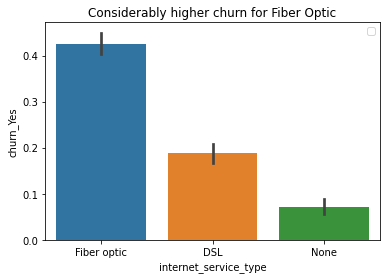

In [49]:
plt.title("Considerably higher churn for Fiber Optic")
sns.barplot(y=telco_y_train, x= 'internet_service_type', data=telco_X_train)
plt.legend()
plt.show()

# definitely one of the areas i want to pursue.  chi^2 test on this one


In [50]:
observed_internet_service_type = pd.crosstab(telco_X_train['internet_service_type_Fiber optic'], telco_y_train)
observed_internet_service_type

churn_Yes,0,1
internet_service_type_Fiber optic,,
0,1922,323
1,975,723


    - 𝐻𝑜 : Fiber Optic internet service type is unrelated to churn
    - 𝐻𝑎 : Fiber Optic internet service type is related to churn

In [51]:
chi2, p, degf, expected = stats.chi2_contingency(observed_internet_service_type)
print('Observed\n')
print(observed_internet_service_type.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[1922  323]
 [ 975  723]]
---
Expected

[[1649  595]
 [1247  450]]
---

chi^2 = 392.7867
p     = 0.0000
We reject the null hypothesis


<AxesSubplot:title={'center':'Way higher churn for electronic check'}, xlabel='payment_type', ylabel='churn_Yes'>

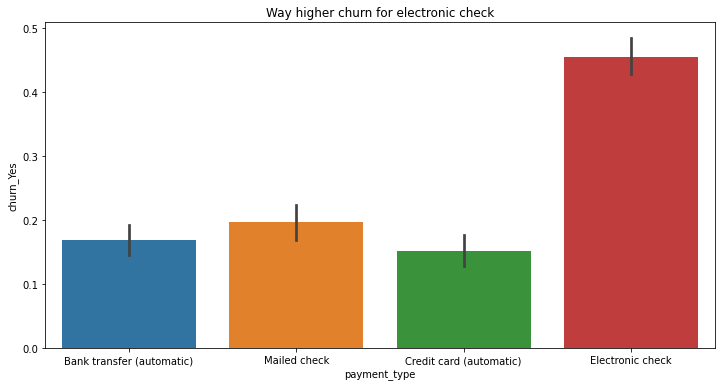

In [52]:
plt.figure(figsize=(12,6))
plt.title("Way higher churn for electronic check")
sns.barplot(y=telco_y_train, x= 'payment_type', data=telco_X_train)



# chi2 this one for sure

payment_type_Electronic check

In [53]:
# Please don't fail to note that we used the encoded column here, so that we are running the test on echeck only!

observed_payment_type_Electronic_check = pd.crosstab(telco_X_train['payment_type_Electronic check'], telco_y_train)
observed_payment_type_Electronic_check

churn_Yes,0,1
payment_type_Electronic check,,
0,2197,461
1,700,585


    - 𝐻𝑜 : paying by electronic check is unrelated to churn
    - 𝐻𝑎 : paying by electronic check is related to churn

In [54]:
chi2, p, degf, expected = stats.chi2_contingency(observed_payment_type_Electronic_check)
print('Observed\n')
print(observed_payment_type_Electronic_check.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[2197  461]
 [ 700  585]]
---
Expected

[[1952  705]
 [ 944  340]]
---

chi^2 = 351.5197
p     = 0.0000
We reject the null hypothesis


In [55]:
# plt.figure(figsize=(15,6))
# plt.title("Churn increases as do monthly charges, up to a point")
# sns.barplot(y=telco_y_train, x= 'monthly_charges_bins', data=telco_X_train)
# plt.legend()
# plt.show()

# # not worth pursuit

In [56]:
# plt.figure(figsize=(15,6))
# plt.title("Churn is generally highest where total charges are least")
# sns.barplot(y=telco_y_train, x= 'total_charges_bins', data=telco_X_train)
# plt.legend()
# plt.show()
# plt.tight_layout

# # totally non-ground breaking. 

In [57]:
confidence_level = 0.95
alpha = 1 - confidence_level
alpha

0.050000000000000044

In [58]:
corr, p = stats.pearsonr(telco_X_train.total_charges, telco_y_train)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

We reject the null hypothesis


(-0.191381986028363, 7.696699309757277e-34)

#### The below cell is actually checking tenure against total charges.  They are related

- 𝐻𝑜 : tenure and total charges are not linearly correlated
- 𝐻𝑎 : tenure and total charges are linearly correlated

In [59]:
corr, p = stats.pearsonr(telco_X_train.tenure, telco_X_train.total_charges)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

# strong correlation between tenure and total charges, for obvious reasons

We reject the null hypothesis


(0.8267190853307795, 0.0)

In [60]:
corr, p = stats.pearsonr(telco_X_train.tenure, telco_X_train.monthly_charges)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p


# loose correlation between tenure and monthly charges

We reject the null hypothesis


(0.26418098021196357, 5.863503661190746e-64)

# MULTIVARIATE NOTES

## 1. Are those with dependents paying less?

NOTES HERE

In [61]:
#telco_X_train.head(1).T

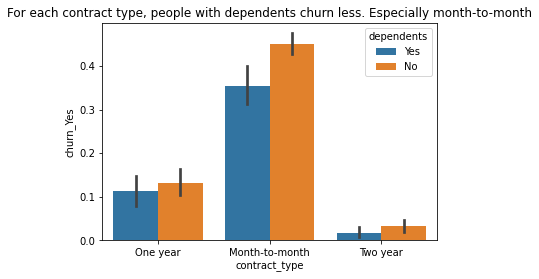

In [62]:
#monthly charges, dependents, churn, contract type

# For each contract type, people with dependents churn less
plt.title("For each contract type, people with dependents churn less. Especially month-to-month")
sns.barplot(x="contract_type", y=telco_y_train, data=telco_X_train, hue="dependents")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

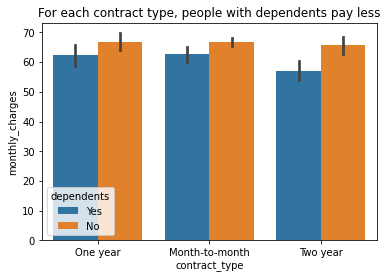

In [63]:
# For each contract type, people with dependents churn less
plt.title("For each contract type, people with dependents pay less")
sns.barplot(x="contract_type", y='monthly_charges', data=telco_X_train, hue="dependents")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

## 2. Are people with paperless billing being charged differently?

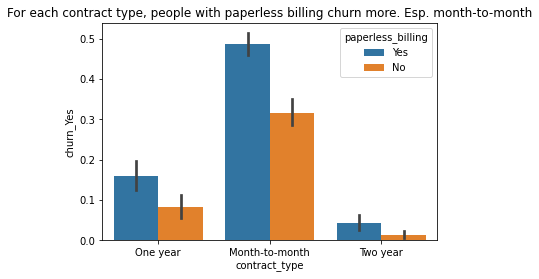

In [64]:
#monthly charges, paperless billing, churn, contract type

# For each contract type, people with dependents churn less
plt.title("For each contract type, people with paperless billing churn more. Esp. month-to-month")
sns.barplot(x="contract_type", y=telco_y_train, data=telco_X_train, hue="paperless_billing")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

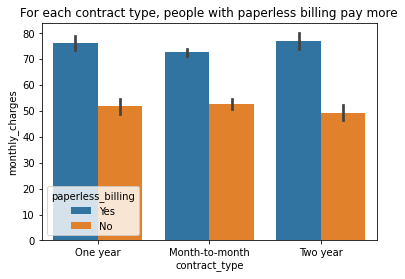

In [65]:
# For each contract type, people with dependents churn less
plt.title("For each contract type, people with paperless billing pay more")
sns.barplot(x="contract_type", y='monthly_charges', data=telco_X_train, hue="paperless_billing")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

## 3. Are people with longer tenure more loyal? Are they being charged more? Less?

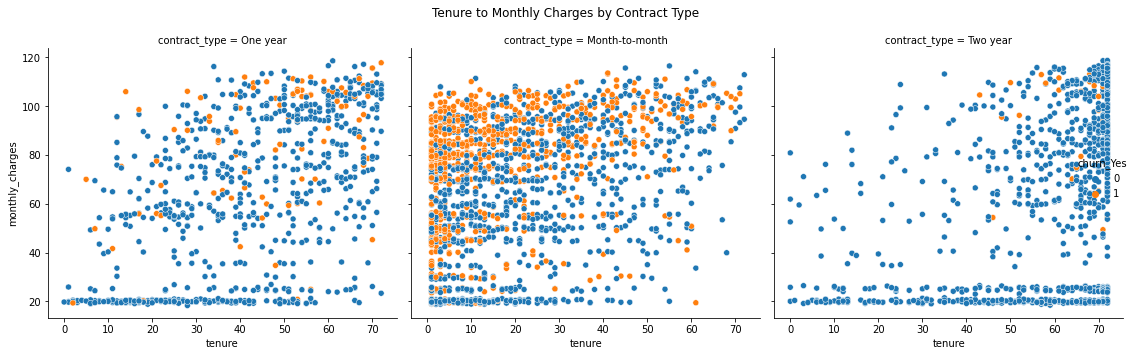

In [66]:
# slight correlation. far less churn and higher tenure in two year contracts.  For what it's worth
rel = sns.relplot(x='tenure', y='monthly_charges', data=telco_X_train, col="contract_type", hue=telco_y_train)
rel.fig.suptitle('Tenure to Monthly Charges by Contract Type') # One way to title a relplot
plt.tight_layout()

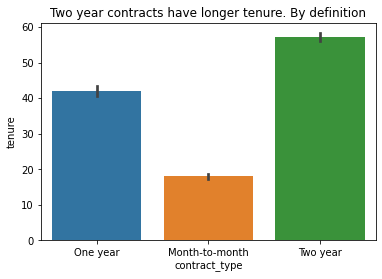

In [67]:
# Two year contracts have longer tenure. This is bivariate btw
plt.title("Two year contracts have longer tenure. By definition")
sns.barplot(x="contract_type", y='tenure', data=telco_X_train)
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

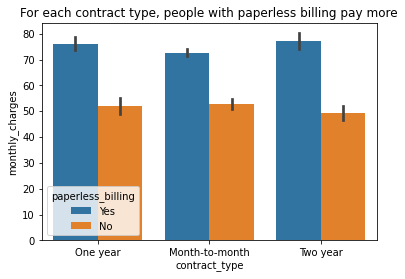

In [68]:
# For each contract type, people with dependents churn less
plt.title("For each contract type, people with paperless billing pay more")
sns.barplot(x="contract_type", y='monthly_charges', data=telco_X_train, hue="paperless_billing")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

## 4. Are senior citizen being charged more for the same service?

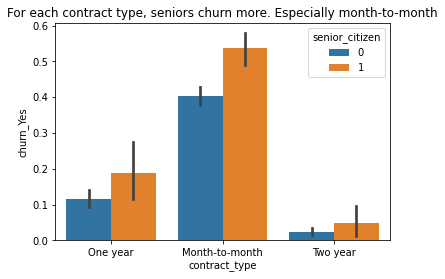

In [69]:
#monthly charges, seniors, churn, contract type

# For each contract type, seniors churn less
plt.title("For each contract type, seniors churn more. Especially month-to-month")
sns.barplot(x="contract_type", y=telco_y_train, data=telco_X_train, hue="senior_citizen")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

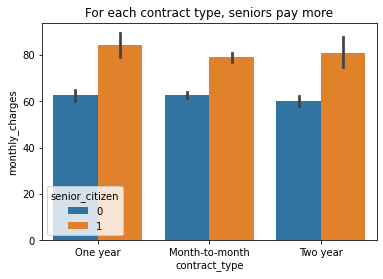

In [70]:
# For each contract type, people with dependents churn less
plt.title("For each contract type, seniors pay more")
sns.barplot(x="contract_type", y='monthly_charges', data=telco_X_train, hue="senior_citizen")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

## 5. Is there a reason for the Fiber Optic churn, outside of price?

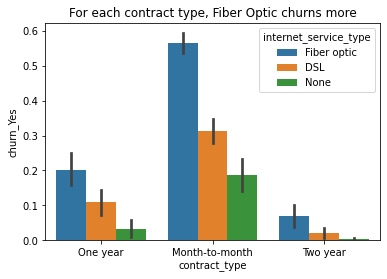

In [71]:
# For each contract type, Fiber Optic churns more
plt.title("For each contract type, Fiber Optic churns more")
sns.barplot(x="contract_type", y=telco_y_train, data=telco_X_train, hue="internet_service_type")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

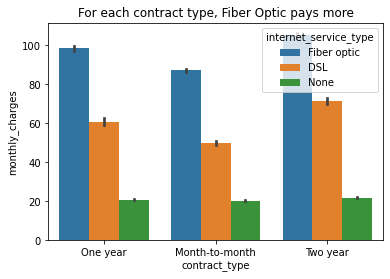

In [72]:
# For each contract type, Fiber Optic churns more
plt.title("For each contract type, Fiber Optic pays more")
sns.barplot(x="contract_type", y="monthly_charges", data=telco_X_train, hue="internet_service_type")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

## 6. Are people paying by electronic check getting a worse deal?

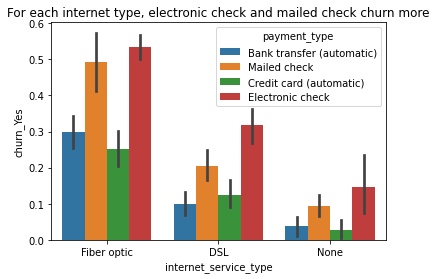

In [73]:
# For each contract type, Fiber Optic churns more
plt.title("For each internet type, electronic check and mailed check churn more")
sns.barplot(x="internet_service_type", y=telco_y_train, data=telco_X_train, hue="payment_type")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

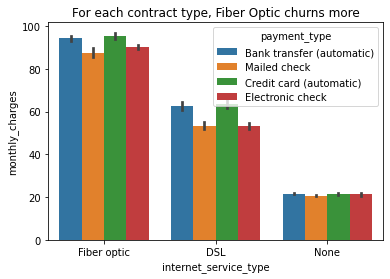

In [74]:
# For each contract type, Fiber Optic churns more
plt.title("For each contract type, Fiber Optic churns more")
sns.barplot(x="internet_service_type", y='monthly_charges', data=telco_X_train, hue="payment_type")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

# ON TO MODELLING

In [75]:
# creating a baseline column valued 0 (because no churn, '0', is the baseline)

telco_X_train['baseline'] = 0
telco_X_validate['baseline'] = 0
telco_X_test['baseline']= 0

In [77]:
#telco_X_train.head(1).T

In [78]:
# the decision tree model was throwing errors bc of the string type data in the train set.
# this code uses a function i made to encode and drop columns for the model.  
# I need to still transform the validate and test sets the same way

telco_X_train_encoded = prepare.cols_to_dummy(telco_X_train)
telco_X_train_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,20.0,39.40,825.4,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,72.0,85.15,6316.2,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [120]:
# there were a large number of NaNs in the resulting df, so this code drops them

telco_X_train_encoded = telco_X_train_encoded.dropna()
telco_X_train_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
3,0.0,20.0,39.40,825.40,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,72.0,85.15,6316.20,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,25.0,35.05,844.45,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0.0,72.0,89.70,6339.30,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12,0.0,72.0,92.65,6733.00,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [119]:
# the decision tree model was throwing errors bc of the string type data in the train set.
# this code uses a function i made to encode and drop columns for the model.  
# I need to still transform the validate and test sets the same way

telco_X_validate_encoded = prepare.cols_to_dummy(telco_X_validate)
telco_X_validate_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,54.0,45.20,2460.55,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,56.0,45.05,2560.10,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# there were a large number of NaNs in the resulting df, so this code drops them

telco_X_validate_encoded = telco_X_validate_encoded.dropna()
telco_X_validate_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
1,0.0,54.0,45.20,2460.55,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,56.0,45.05,2560.10,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,71.0,58.25,4145.90,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,61.0,88.10,5526.75,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,70.0,57.80,4039.30,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [122]:
# the decision tree model was throwing errors bc of the string type data in the train set.
# this code uses a function i made to encode and drop columns for the model.  
# I need to still transform the validate and test sets the same way

telco_X_test_encoded = prepare.cols_to_dummy(telco_X_test)
telco_X_test_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
0,0.0,65.0,90.45,5957.9,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# there were a large number of NaNs in the resulting df, so this code drops them

telco_X_test_encoded = telco_X_test_encoded.dropna()
telco_X_test_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
0,0.0,65.0,90.45,5957.9,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13,0.0,48.0,79.65,3870.3,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18,0.0,72.0,63.80,4684.3,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29,0.0,62.0,60.15,3753.2,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32,0.0,63.0,83.50,5435.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [105]:
#telco_X_train_encoded.dtypes

# Decision Tree Model

In [107]:
#baseline accuracy
baseline_accuracy = (telco_y_train == telco_X_train.baseline).mean()

# print(f'model1 accuracy: {model1_accuracy:.2%}')
# print(f'model2 accuracy: {model2_accuracy:.2%}')
# print(f'model3 accuracy: {model3_accuracy:.2%}')
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.47%


In [91]:
telco_y_train.dtypes

dtype('uint8')

In [108]:
# Create the Decision Tree object with desired hyper-parameters.
clf = DecisionTreeClassifier(max_depth=4, random_state=123)
clf

DecisionTreeClassifier(max_depth=4, random_state=123)

In [109]:
# Fit the model (i.e. apply the algorithm to your unique set of data so that the algorithm can identify a pattern)
# model.fit(X, y)

clf = clf.fit(telco_X_train_encoded, telco_y_train)
clf

DecisionTreeClassifier(max_depth=4, random_state=123)

In [110]:
import graphviz
from graphviz import Graph

dot_data = export_graphviz(clf, feature_names= telco_X_train_encoded.columns,
                           rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'



### What are we optimizing for?  ACCURACY bc we want to pinpoint the best we can the customers who will churn. Not a case of trying to prevent false positives or false negatives, etc.  

In [111]:
# make prediction on train obeservations
# this would be my csv of predictions, if i were to choose this model in the end


y_pred = clf.predict(telco_X_train_encoded)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [112]:
y_pred_proba = clf.predict_proba(telco_X_train_encoded)
y_pred_proba

array([[0.74677608, 0.25322392],
       [0.8976378 , 0.1023622 ],
       [0.74677608, 0.25322392],
       ...,
       [0.74677608, 0.25322392],
       [0.74677608, 0.25322392],
       [0.74677608, 0.25322392]])

In [113]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(telco_X_train_encoded, telco_y_train)))

Accuracy of Decision Tree classifier on training set: 0.74


In [114]:
# confusion matrix

confusion_matrix(telco_y_train, y_pred)

array([[2880,   17],
       [1022,   24]])

In [115]:
labels = sorted(telco_y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(telco_y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,2880,17
1,1022,24


In [116]:
print(classification_report(telco_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85      2897
           1       0.59      0.02      0.04      1046

    accuracy                           0.74      3943
   macro avg       0.66      0.51      0.45      3943
weighted avg       0.70      0.74      0.63      3943



## I'm going to iterate at different max depths in the following cell

In [118]:
# This is Adam's 'for' loop
for i in range(1,21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(telco_X_train_encoded, telco_y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(telco_X_train_encoded)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(telco_y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 1
                     0       1  accuracy    macro avg  weighted avg
precision     0.734720     0.0   0.73472     0.367360      0.539813
recall        1.000000     0.0   0.73472     0.500000      0.734720
f1-score      0.847076     0.0   0.73472     0.423538      0.622363
support    2897.000000  1046.0   0.73472  3943.000000   3943.000000

Tree with max depth of 2
                     0       1  accuracy    macro avg  weighted avg
precision     0.734720     0.0   0.73472     0.367360      0.539813
recall        1.000000     0.0   0.73472     0.500000      0.734720
f1-score      0.847076     0.0   0.73472     0.423538      0.622363
support    2897.000000  1046.0   0.73472  3943.000000   3943.000000

Tree with max depth of 3
                     0       1  accuracy    macro avg  weighted avg
precision     0.734720     0.0   0.73472     0.367360      0.539813
recall        1.000000     0.0   0.73472     0.500000      0.734720
f1-score      0.847076     0.0   0.7347

In [124]:
#adam's code for a nice, clean view:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(1, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(telco_X_train_encoded, telco_y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(telco_X_train_encoded, telco_y_train)
    
    out_of_sample_accuracy = tree.score(telco_X_validate_encoded, telco_y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.734720,0.734477,0.000243
1,2,0.734720,0.734477,0.000243
2,3,0.734720,0.734477,0.000243
3,4,0.736495,0.727380,0.009115
4,5,0.741314,0.722649,0.018664
5,6,0.748922,0.717327,0.031595
6,7,0.757038,0.717918,0.039119
7,8,0.769972,0.703134,0.066838
8,9,0.786457,0.697812,0.088645
9,10,0.800406,0.693081,0.107325


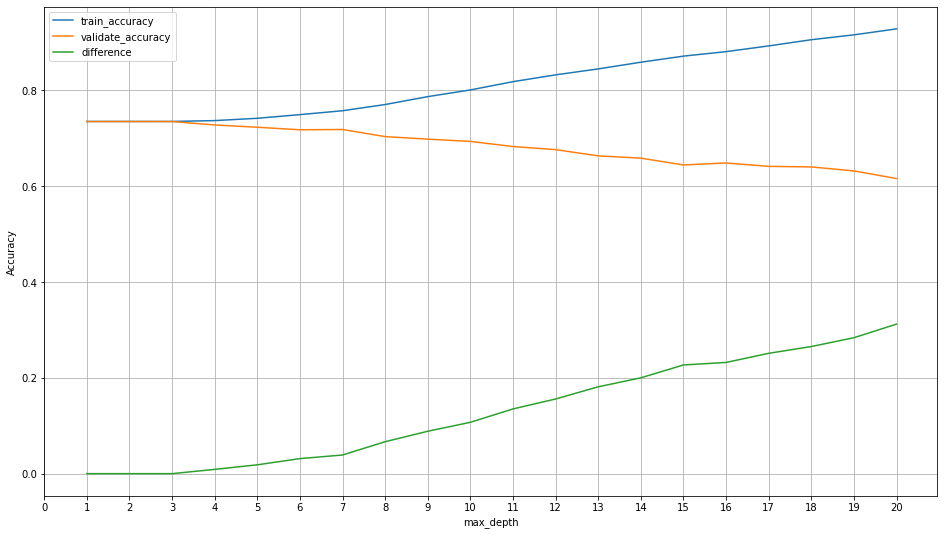

In [126]:
# df.set_index('max_depth').plot

# review ravinder's graph here

df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [125]:
# here, we're comparing differences between the train and validate data sets
# we're tossing any differences above a certain amount (.10) and ordering by difference as a tie-breaker
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

# the best max_depth, following these criteria, is 5

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.734720,0.734477,0.000243
1,2,0.734720,0.734477,0.000243
2,3,0.734720,0.734477,0.000243
3,4,0.736495,0.727380,0.009115
4,5,0.741314,0.722649,0.018664
6,7,0.757038,0.717918,0.039119
5,6,0.748922,0.717327,0.031595
7,8,0.769972,0.703134,0.066838
8,9,0.786457,0.697812,0.088645


In [127]:
#baseline accuracy
baseline_accuracy = (telco_y_train == telco_X_train.baseline).mean()

# print(f'model1 accuracy: {model1_accuracy:.2%}')
# print(f'model2 accuracy: {model2_accuracy:.2%}')
# print(f'model3 accuracy: {model3_accuracy:.2%}')
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.47%


## Given the baseline accuracy, none of the Decision Tree models is very satisfactory (given we are excluding those that are over-fit)

### In the event you were to use this model, don't forget to do a new confusion matrix and classification report for the max_depth you chose

# Random Forest

In [129]:
# fitting a single RF before continuing to iterate
# assign rf variable

rf = RandomForestClassifier(max_depth = 10, )
rf

RandomForestClassifier(max_depth=10)

In [131]:
# fit the train data to it

rf = rf.fit(telco_X_train_encoded, telco_y_train)
rf

RandomForestClassifier(max_depth=10)

In [133]:
# the weight assigned to each feature in implementation

print(rf.feature_importances_)

[0.02238709 0.13140337 0.18342901 0.18031811 0.03192509 0.02667982
 0.0263715  0.0075639  0.00680699 0.01979832 0.00128904 0.02080905
 0.00121603 0.02283522 0.00121783 0.02055207 0.00111265 0.01975516
 0.00137552 0.01746595 0.00192914 0.01862086 0.02745162 0.01924646
 0.016454   0.0095706  0.001204   0.02304716 0.01967492 0.01907864
 0.0105259  0.01213385 0.00900288 0.00743305 0.00955813 0.01038725
 0.01015001 0.00926292 0.0081453  0.00821839 0.00459318 0.        ]


In [135]:
# This would be your csv to include, if the model is ultimately chosen

y_pred = rf.predict(telco_X_train_encoded)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [136]:
# and the probability assigned to each customer

y_pred_proba = rf.predict_proba(telco_X_train_encoded)
y_pred_proba

array([[0.83412644, 0.16587356],
       [0.72190967, 0.27809033],
       [0.62245909, 0.37754091],
       ...,
       [0.78590518, 0.21409482],
       [0.53148397, 0.46851603],
       [0.80654895, 0.19345105]])

In [137]:
# evaluate rf results on train:

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(telco_X_train_encoded, telco_y_train)))

Accuracy of random forest classifier on training set: 0.75


In [141]:
# confusion matrix

labels = sorted(telco_y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(telco_y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,2897,0
1,987,59


In [143]:
# classification report for the RF model

print(classification_report(telco_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85      2897
           1       1.00      0.06      0.11      1046

    accuracy                           0.75      3943
   macro avg       0.87      0.53      0.48      3943
weighted avg       0.81      0.75      0.66      3943



In [144]:
# attempting to create lists that i can pack into a DF for easy comparison below
# create an empty list to fill in the for loop

# also, this for loop is creating a list of every possible min_samples_leaf for every max_depth
        # in other words, 20 max_depths * 20 min_leaves


metrics = []

for i in range(20,0, -1):
    for n in range(1, 21):
        # Make the model
        forest = RandomForestClassifier(max_depth=i, min_samples_leaf=n)#, random_state=123)

        #why isn't the random_state argument working?

        # Fit the model (on train and only train)
        forest.fit(telco_X_train_encoded, telco_y_train)

        # Use the model
        # We'll evaluate the model's performance on train, first
        in_sample_accuracy = forest.score(telco_X_train_encoded, telco_y_train)
    
        out_of_sample_accuracy = forest.score(telco_X_validate_encoded, telco_y_validate)

        output = {
            "max_depth": i,
            "min_leaves": n,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy
        }

        metrics.append(output)

df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,min_leaves,train_accuracy,validate_accuracy,difference
0,20,1,0.997971,0.713187,0.284784
1,20,2,0.863302,0.731520,0.131782
2,20,3,0.780624,0.732703,0.047921
3,20,4,0.749683,0.733294,0.016389
4,20,5,0.738270,0.734477,0.003794
...,...,...,...,...,...
395,1,16,0.734720,0.734477,0.000243
396,1,17,0.734720,0.734477,0.000243
397,1,18,0.734720,0.734477,0.000243
398,1,19,0.734720,0.734477,0.000243


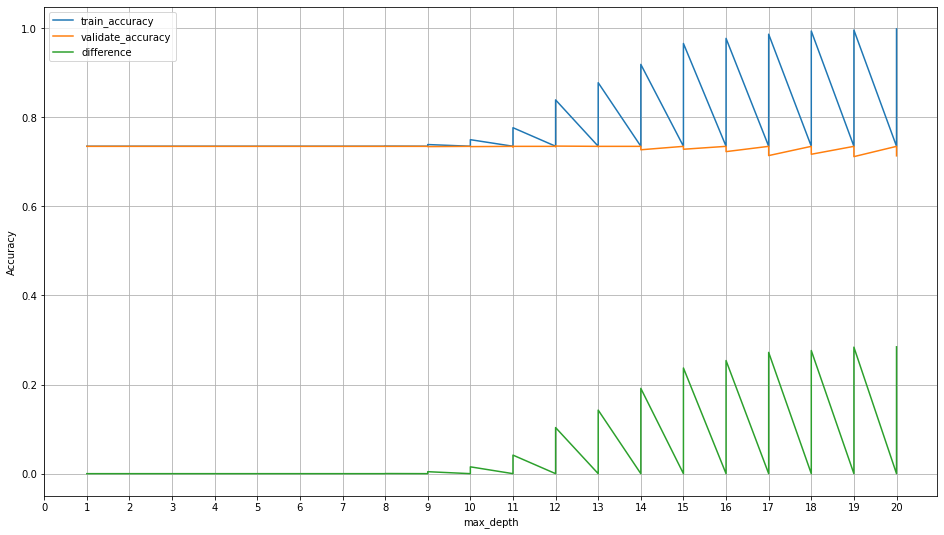

In [145]:
# Graph of the above:

df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [147]:
# which one did best here?

df[df.difference <= 0.05].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,max_depth,min_leaves,train_accuracy,validate_accuracy,difference
7,20,8,0.734720,0.734477,0.000243
9,20,10,0.734720,0.734477,0.000243
10,20,11,0.734720,0.734477,0.000243
11,20,12,0.734720,0.734477,0.000243
12,20,13,0.734720,0.734477,0.000243
...,...,...,...,...,...
82,16,3,0.770987,0.733294,0.037693
63,17,4,0.746386,0.732703,0.013683
2,20,3,0.780624,0.732703,0.047921
22,19,3,0.780878,0.732703,0.048175


In [148]:
#baseline accuracy
baseline_accuracy = (telco_y_train == telco_X_train.baseline).mean()

# print(f'model1 accuracy: {model1_accuracy:.2%}')
# print(f'model2 accuracy: {model2_accuracy:.2%}')
# print(f'model3 accuracy: {model3_accuracy:.2%}')
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.47%


## We are still below baseline for our accuracy : (

# KNN Model

In [257]:
#telco_X_train_encoded.info()

In [343]:
# per lecture and exercises, it's important to reduce the number of features when usin KNN bc of problems
# with computation and dimensionality. We will choose the columns to use here.

#(first, let's try with all features for fun)

x_cols = ['senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'partner_Yes','dependents_Yes',
            'paperless_billing_Yes',
            'payment_type_Electronic check']

# x_cols = ['senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'partner_Yes','dependents_Yes',
#             'paperless_billing_Yes', 'contract_type_One year', 'contract_type_Two year', 'payment_type_Credit card (automatic)',
#             'payment_type_Electronic check','payment_type_Mailed check']


X_train, y_train = telco_X_train_encoded[x_cols], telco_y_train
X_validate, y_validate = telco_X_validate_encoded[x_cols], telco_y_validate
X_test, y_test = telco_X_test_encoded[x_cols], telco_y_test

### Taking a stab at scaling here:

In [344]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [345]:
# fitting with a 'distance' weight did not help.  got 100% for train validate approached baseline (but less)
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm ='auto')

In [346]:
# knn.fit(telco_X_train_encoded, telco_y_train)

knn.fit(X_train_scaled, telco_y_train)

KNeighborsClassifier(n_neighbors=3)

In [347]:
# again, yor csv if this model is selected

# y_pred = knn.predict(telco_X_train_encoded)
y_pred = knn.predict(X_train_scaled)
y_pred[0:5]

array([0, 0, 0, 0, 1], dtype=uint8)

In [348]:
# y_pred_proba = knn.predict_proba(telco_X_train_encoded)
# knn.classes_, y_pred_proba[0:10]


y_pred_proba = knn.predict_proba(X_train_scaled)
knn.classes_, y_pred_proba[0:10]

(array([0, 1], dtype=uint8),
 array([[1.        , 0.        ],
        [0.66666667, 0.33333333],
        [0.66666667, 0.33333333],
        [1.        , 0.        ],
        [0.33333333, 0.66666667],
        [0.66666667, 0.33333333],
        [1.        , 0.        ],
        [0.66666667, 0.33333333],
        [1.        , 0.        ],
        [0.66666667, 0.33333333]]))

In [349]:
# print('Accuracy of KNN classifier on training set: {:.2f}'
#      .format(knn.score(telco_X_train_encoded, telco_y_train)))

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, telco_y_train)))

Accuracy of KNN classifier on training set: 0.80


In [350]:
# confusion matrix

# labels = sorted(telco_y_train.unique())
# print('Actual on the left, predicted on the top')
# pd.DataFrame(confusion_matrix(telco_y_train, y_pred), index=labels, columns=labels)

labels = sorted(telco_y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(telco_y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,2681,216
1,569,477


In [351]:
# classification report for the RF model

print(classification_report(telco_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2897
           1       0.69      0.46      0.55      1046

    accuracy                           0.80      3943
   macro avg       0.76      0.69      0.71      3943
weighted avg       0.79      0.80      0.79      3943



### OK, feeling a little better now, at least my accuracy is currently beating baseline

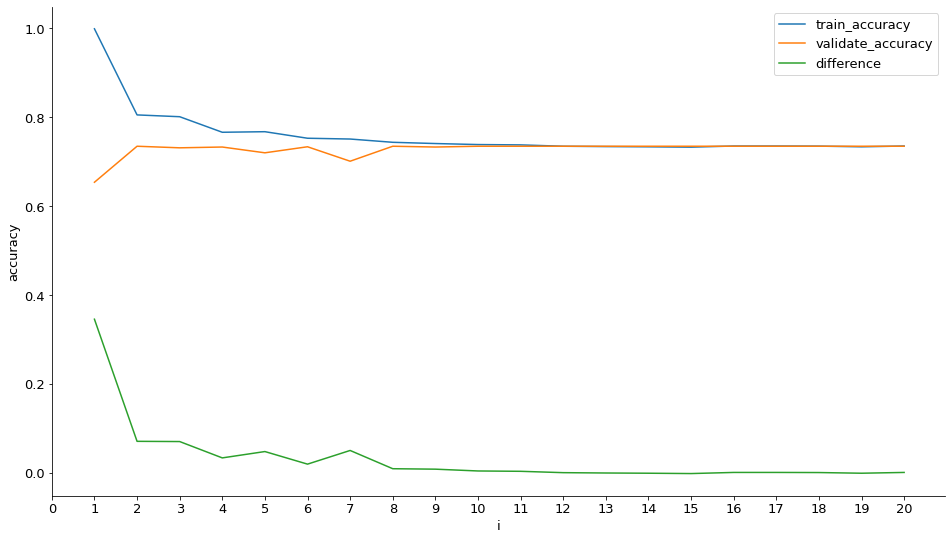

In [352]:
metrics = []

for i in range(1,21):
    # Make the model
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')


    # Fit the model (on train and only train)
    knn.fit(X_train_scaled, telco_y_train)

    # We'll evaluate the model's performance on train and validate
    train_accuracy = knn.score(X_train_scaled, telco_y_train)
    validate_accuracy = knn.score(X_validate, telco_y_validate)

    output = {
        "i": i,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)
    # Produce the classification report on the actual y values and this model's predicted y values
results = pd.DataFrame(metrics)
results["difference"] = results.train_accuracy - results.validate_accuracy
    
# plot it
results.set_index('i').plot(figsize = (16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [353]:
results[results.difference <= 0.1].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,i,train_accuracy,validate_accuracy,difference
14,15,0.732437,0.734477,-0.002039
13,14,0.733198,0.734477,-0.001279
18,19,0.733198,0.734477,-0.001279
12,13,0.733705,0.734477,-0.000771
11,12,0.734466,0.734477,-0.000010
17,18,0.734720,0.734477,0.000243
15,16,0.734973,0.734477,0.000497
16,17,0.734973,0.734477,0.000497
19,20,0.734973,0.734477,0.000497
10,11,0.737510,0.734477,0.003033


In [322]:
#baseline accuracy
baseline_accuracy = (telco_y_train == telco_X_train.baseline).mean()

# print(f'model1 accuracy: {model1_accuracy:.2%}')
# print(f'model2 accuracy: {model2_accuracy:.2%}')
# print(f'model3 accuracy: {model3_accuracy:.2%}')
print(f'baseline accuracy: {baseline_accuracy:.3%}')

baseline accuracy: 73.472%


# Still not beating baseline.  

In [169]:
telco_X_train_encoded.head(1)

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,"monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
3,0.0,20.0,39.4,825.4,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic Regression Model

In [354]:
# X_train is the scaled data set

# Define the logistic regression model


logit = LogisticRegression(C=100)
#  fit the model on train data
logit.fit(X_train, telco_y_train)

LogisticRegression(C=100)

In [355]:
# now use the model to make predictions
y_pred = logit.predict(X_train)
y_pred[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [356]:
# y_pred_proba = logit.predict_proba(telco_X_train_encoded)
# y_pred_proba[0:10]

y_pred_proba = logit.predict_proba(X_train)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
y_pred_proba.head()

,no churn,churn
0,0.730609,0.269391
1,0.754329,0.245671
2,0.735544,0.264456
3,0.740959,0.259041
4,0.740929,0.259071


In [357]:
# classification report


print(classification_report(telco_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



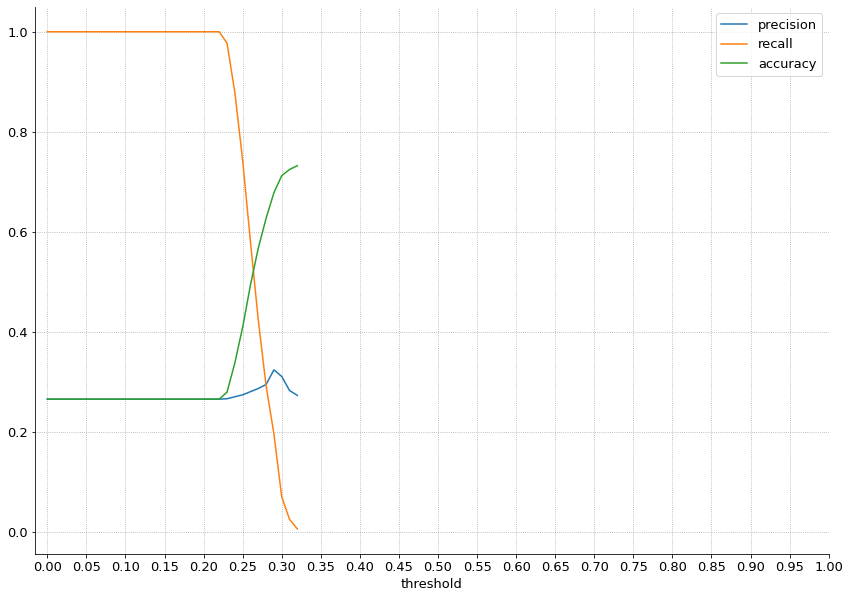

In [358]:
import logistic_regression_util

# plot metrics vs thresholds
logistic_regression_util.plot_metrics_by_thresholds(telco_y_train, y_pred_proba.churn)

In [359]:
def evaluate_model(c):
    model = sklearn.linear_model.LogisticRegression(C=c)
    model.fit(telco_X_train_encoded, telco_y_train)
    accuracy = model.score(telco_X_validate_encoded, telco_y_validate)
    coefs = dict(zip(telco_X_train_encoded.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]


(pd.DataFrame(models).round(3)
 .set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of different C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3)
)

,,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,"monthly_charges_bins_(25.05, 58.83]","monthly_charges_bins_(58.83, 79.1]","monthly_charges_bins_(79.1, 94.25]","monthly_charges_bins_(94.25, 118.75]","total_charges_bins_(116.112, 398.55]","total_charges_bins_(398.55, 838.362]","total_charges_bins_(838.362, 1394.55]","total_charges_bins_(1394.55, 2290.225]","total_charges_bins_(2290.225, 3786.6]","total_charges_bins_(3786.6, 5606.375]","total_charges_bins_(5606.375, 8684.8]",baseline
C,accuracy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.001,0.734,0.003,-0.016,-0.012,0.000,-0.025,-0.011,-0.003,-0.026,-0.013,-0.002,-0.036,-0.007,-0.036,-0.003,-0.036,-0.003,-0.036,-0.002,-0.036,0.009,-0.036,0.014,0.005,-0.007,-0.006,0.018,-0.036,-0.001,0.010,-0.033,-0.028,0.017,0.003,0.003,-0.016,-0.000,0.002,0.001,-0.002,0.013,-0.008,0.000
0.01,0.734,0.018,-0.003,-0.009,0.000,-0.041,-0.054,0.068,-0.027,-0.117,-0.024,-0.053,-0.036,-0.053,-0.015,-0.053,-0.037,-0.053,0.003,-0.053,0.024,-0.053,0.090,0.069,-0.006,-0.007,0.091,-0.053,0.037,0.073,-0.018,-0.141,0.047,-0.037,0.034,-0.009,0.065,-0.008,-0.039,-0.088,0.068,-0.020,0.000
0.1,0.734,0.007,-0.007,-0.011,0.000,-0.057,-0.024,-0.007,-0.060,-0.029,-0.004,-0.083,-0.016,-0.083,-0.007,-0.083,-0.006,-0.083,-0.005,-0.083,0.019,-0.083,0.031,0.011,-0.016,-0.013,0.042,-0.083,-0.003,0.023,-0.075,-0.064,0.038,0.006,0.007,-0.037,-0.000,0.004,0.002,-0.005,0.030,-0.019,0.000
1.0,0.734,0.010,0.000,-0.011,0.000,-0.110,-0.039,0.080,-0.038,-0.183,-0.015,-0.078,-0.090,-0.078,-0.049,-0.078,-0.055,-0.078,-0.031,-0.078,0.053,-0.078,0.116,0.073,-0.021,-0.003,0.156,-0.078,0.017,0.064,-0.114,-0.294,0.102,-0.027,0.069,-0.058,0.059,0.009,-0.037,-0.090,0.104,-0.038,0.000
10.0,0.734,0.008,0.001,-0.012,0.000,-0.050,-0.066,0.162,-0.041,-0.219,-0.060,-0.085,-0.047,-0.085,-0.018,-0.085,-0.052,-0.085,0.032,-0.085,0.059,-0.085,0.174,0.116,0.001,0.007,0.147,-0.085,0.066,0.086,-0.023,-0.282,0.102,-0.076,0.076,-0.020,0.119,-0.007,-0.073,-0.155,0.127,-0.036,0.000
100.0,0.734,0.011,-0.003,-0.011,0.000,-0.108,-0.034,0.053,-0.035,-0.157,-0.003,-0.070,-0.087,-0.070,-0.048,-0.070,-0.050,-0.070,-0.039,-0.070,0.045,-0.070,0.092,0.057,-0.024,-0.006,0.141,-0.070,0.007,0.057,-0.115,-0.258,0.086,-0.014,0.059,-0.057,0.042,0.010,-0.026,-0.069,0.087,-0.034,0.000
1000.0,0.734,-0.003,-0.002,-0.011,0.000,-0.064,-0.043,0.160,-0.037,-0.208,-0.061,-0.081,-0.057,-0.081,-0.027,-0.081,-0.050,-0.081,0.024,-0.081,0.063,-0.081,0.163,0.107,-0.001,0.010,0.141,-0.081,0.052,0.064,-0.051,-0.303,0.123,-0.071,0.077,-0.035,0.104,0.001,-0.067,-0.137,0.131,-0.041,0.000
